### TP noté

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as npr
from scipy.stats import laplace


In [9]:
# Lecture du fichier Bots.txt et conversion des lignes en float
with open("Bots.txt", "r") as file:
    Bots = [float(line.strip()) for line in file if line.strip()]

# Affichage du contenu de la liste Bots
print(Bots)


[4.303168121878827, 3.268017202501059, 3.9411255266296914, 3.0240423447276146, 5.2564720527407, 3.324415807517962, 8.73566721234878, 3.266115133966628, 3.60178011761815, 3.6561396190234823, -2.110966707904929, 3.846567577925762, 3.7266627352020145, 3.052825970191632, -2.3728719169573402, 5.874489598140347, 2.6880031746009325, 6.409971506054126, 2.087359581231536, 4.162705386763174, 3.536612591358097, 5.071410109796111, 3.6537940123055903, 4.477903836636994, 3.420163183529952, 3.576490580998542, 3.990141763252725, 2.8321789081909867, -0.5066152732435649, 6.597380199716632, 2.577315860657169, 3.8652693423307896, 4.2198591438337045, 3.6345303173627275, 3.76965201359171, -2.218464675593097, 3.896815789153468, 3.3642482161861476, 3.71755954532998, 3.2529137823175134, 3.524173466198525, 3.8527270364484174, 4.553787101456215, 3.4128412300075497, 3.835106337511662, 2.7814387076450457, 4.058043067762877, 2.589663363187219, 3.773333996513271, 3.530769780064519, 3.2608235844079503, -1.15166257315

Text(0.5, 1.0, 'Histogramme des données')

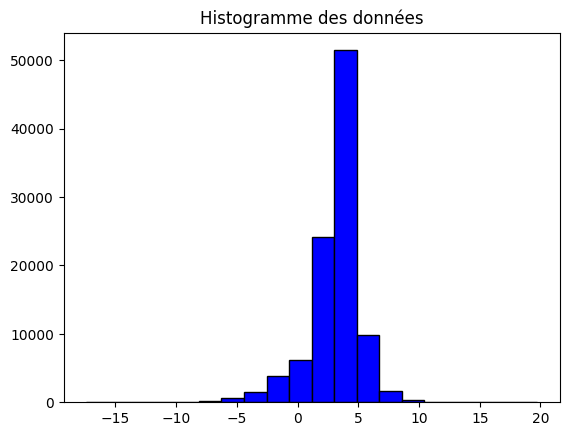

In [ ]:
#l'histogramme des données dans un ordre de grandeur des parametre du modele
plt.hist(Bots, bins=20, color='blue', edgecolor='black')
plt.title('Histogramme des données')



In [ ]:
def w(x, mu, b):
    return np.exp(-np.abs(x-mu)/b)/2/b

In [20]:
# Fonction f1
def f1(w, x, mu):
    return np.sum(w * np.abs(x - mu))

# Fonction f2
def f2(w, x, mu):
    return np.sum((1 - w) * np.abs(x - mu))

# Gradient de f1
def grad_f1(w, x, mu):
    return w * np.sign(x - mu)

# Gradient de f2
def grad_f2(w, x, mu):
    return -(1 - w) * np.sign(x - mu)

# Algorithme de gradient stochastique pour minimiser mu1 et mu2
def gradient_stochastique(initial_mu1, initial_mu2, n_simulations, w, x, a, b):
    mu1 = initial_mu1
    mu2 = initial_mu2
    mu1_ = [mu1]
    mu2_ = [mu2]
    
    for i in range(1, n_simulations + 1):
        # Générer une nouvelle valeur de X selon la loi donnée (en choisissant aléatoirement entre 1 et -1)
        u = npr.rand()
        x_i = 1 if u < 0.5 else -1
        
        # Taux d'apprentissage
        epsilon = a / (b + i)
        
        # Calcul du gradient stochastique pour f1 et f2
        grad1 = grad_f1(w, x_i, mu1)
        grad2 = grad_f2(w, x_i, mu2)
        
        # Mise à jour de mu1 et mu2
        mu1 = mu1 - epsilon * grad1
        mu2 = mu2 - epsilon * grad2
        
        # Sauvegarde de l'historique
        mu1_.append(mu1)
        mu2_.append(mu2)
    
    return mu1_, mu2_

In [34]:
from scipy.stats import laplace
# Algorithme EM avec gradient stochastique pour mise à jour de mu1, mu2
def EM_Laplace(data, max_iter=100, tol=1e-5, lr=0.2, a=0.1, b=1):
    # Initialisation robuste
    pi = 0.5  # Ajusté selon la proportion attendue
    mu1, mu2 = np.percentile(data, [30, 70])  # Séparation initiale
    s1 = s2 = np.mean(np.abs(data - np.median(data)))  # Échelle initiale
    
    prev_params = np.array([pi, mu1, s1, mu2, s2])
    history = []
    
    for iter in range(max_iter):
        # Étape E: Calcul des responsabilités (poids w)
        dens1 = laplace.pdf(data, loc=mu1, scale=s1)
        dens2 = laplace.pdf(data, loc=mu2, scale=s2)
        w = (pi * dens1) / np.clip(pi*dens1 + (1-pi)*dens2, 1e-10, None)
        
        # Étape M: Mise à jour des paramètres
        pi_new = np.mean(w)
        
        # Mise à jour des μ avec gradient stochastique
        mu1_new = gradient_stochastique(mu1, mu2, 100, w, data, lr, 1)[0][-1]  
        mu2_new = gradient_stochastique(mu1, mu2, 100, 1-w, data, lr, 1)[1][-1]  
        
        # Mise à jour des échelles avec régularisation
        s1_new = np.sum(w * np.abs(data - mu1_new)) / (np.sum(w) + 1e-8)
        s2_new = np.sum((1-w) * np.abs(data - mu2_new)) / (np.sum(1-w) + 1e-8)
        
            
        prev_params = current_params
        pi, mu1, s1, mu2, s2 = current_params
        
    return pi, mu1, s1, mu2, s2, np.array(history)

# Lecture des données
with open("Bots.txt", "r") as file:
    Bots = np.array([float(line.strip()) for line in file if line.strip()])

# Exécution de l'algorithme EM sur les données
pi, mu1, s1, mu2, s2, history = EM_Laplace(Bots, max_iter=100, tol=1e-5)

# Affichage des résultats finaux
print("\nParamètres finaux après convergence :")
print(f"• π = {pi:.4f} (proportion d'utilisateurs normaux)")
print(f"• Groupe 1 (normal): μ = {mu1:.4f}, s = {s1:.4f}")
print(f"• Groupe 2 (anormal): μ = {mu2:.4f}, s = {s2:.4f}")




NameError: name 'current_params' is not defined